# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [2]:
noise = .2
# "Men like Adidas"
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


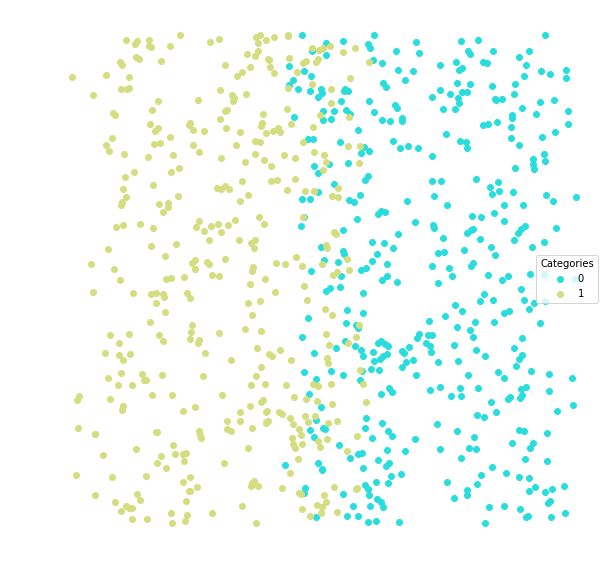

In [3]:
lucem_illud_2020.plotter(dfTrain)

In [4]:
# Old ladies and young men like Nike
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


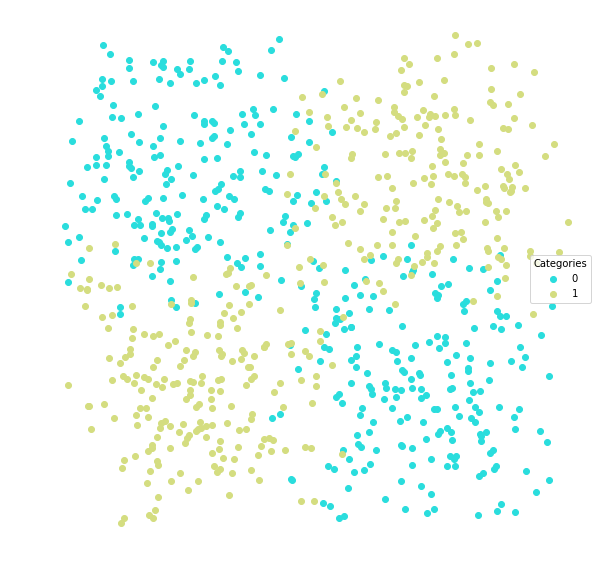

In [5]:
lucem_illud_2020.plotter(dfTrain)

In [6]:
# middle aged, middle income people like vintage Mustangs
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


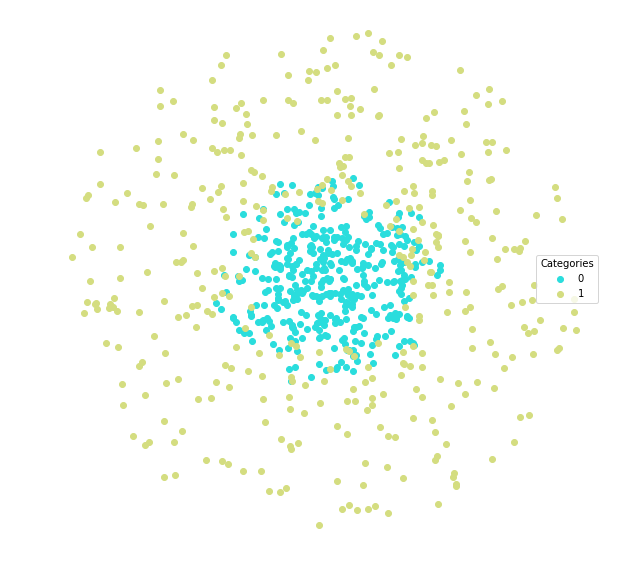

In [7]:
lucem_illud_2020.plotter(dfTrain)

In [8]:
# Complete randomness
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


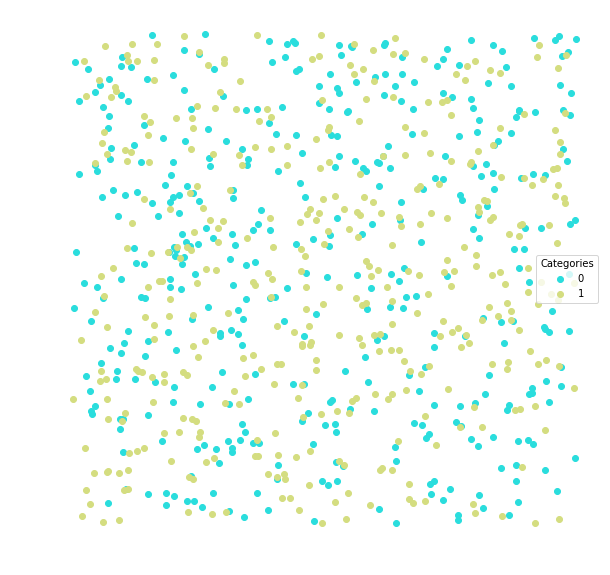

In [9]:
lucem_illud_2020.plotter(dfTrain)

In [10]:
# 5 classes are placed as bivariate Gaussians at random locations
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

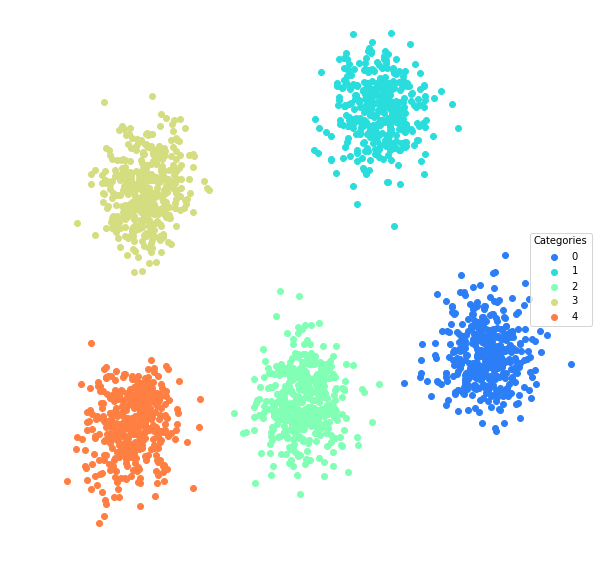

In [11]:
lucem_illud_2020.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [12]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [13]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [14]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,1.0,1.0,0.0,1.0,1.0
1,1.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,1.0,1.0
3,1.0,1.0,0.0,1.0,1.0
4,1.0,1.0,0.0,1.0,1.0


This lets us look at which classes do better:

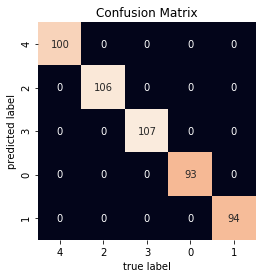

In [15]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

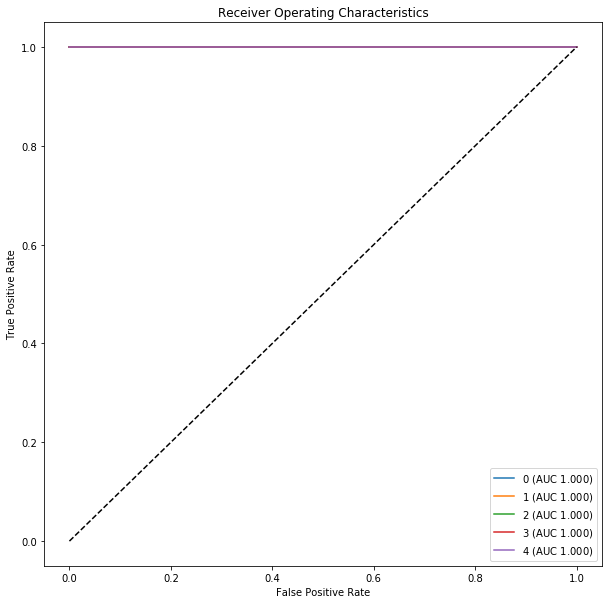

In [16]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

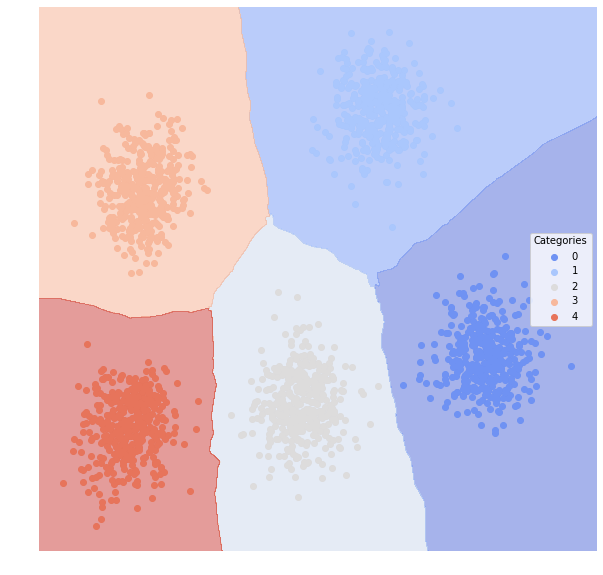

In [17]:
lucem_illud_2020.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [18]:
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Spam
Loading Ham
Converting to vectors


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


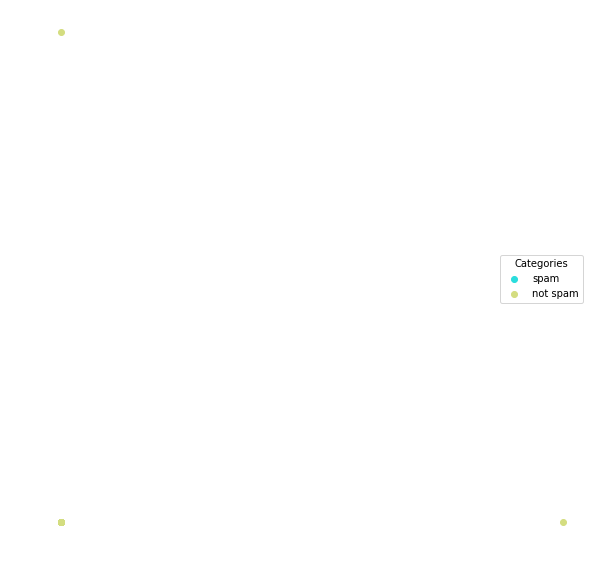

In [19]:
lucem_illud_2020.plotter(dfTrain)

In [20]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [21]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
spam,0.751648,0.520464,0.087719,0.859375,0.518868
not spam,0.751648,0.916610,0.087719,0.917742,0.984429


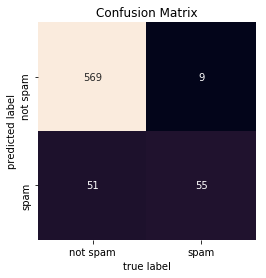

In [23]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

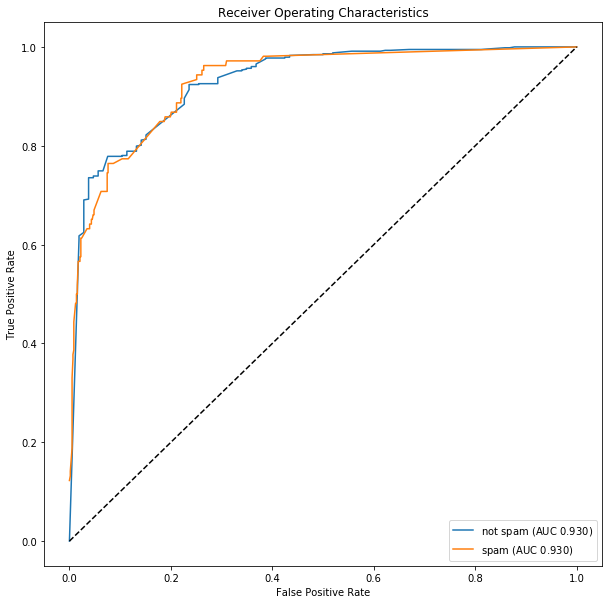

In [24]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


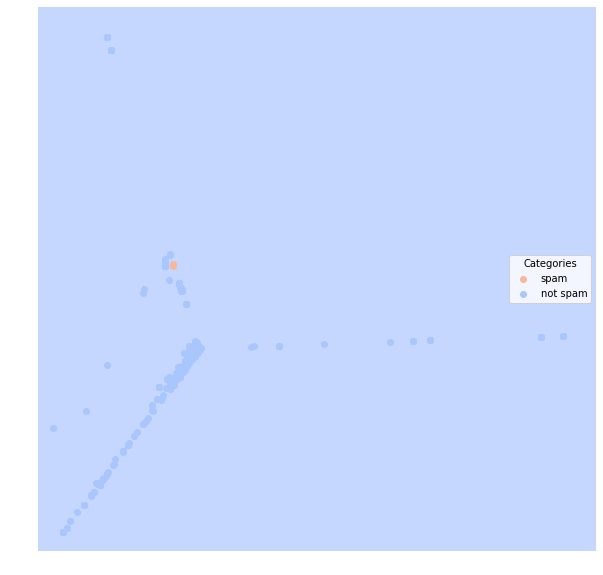

In [25]:
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

## My solution with simulated data

I'll use the different four ways of generating data described above and combine them with two different `noise` values: 0.3 and 0.6. Then, I'll use a noise of 0.85 with `targetSplit()` and `xorSplit`.

In [26]:
noise1 = .3
noise2 = .6
noise3 = .85

In [27]:
dfTrain1, dfTest1 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise1))
dfTrain2, dfTest2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise1))
dfTrain3, dfTest3 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise1))
dfTrain4, dfTest4 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise1))

dfTrain5, dfTest5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise2))
dfTrain6, dfTest6 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise2))
dfTrain7, dfTest7 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise2))
dfTrain8, dfTest8 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise2))

dfTrain9, dfTest9 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise3))
dfTrain10, dfTest10 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise3))

In [28]:
total_train = [dfTrain1, dfTrain2, dfTrain3, dfTrain4, dfTrain5, dfTrain6, dfTrain7, dfTrain8, dfTrain9, dfTrain10]
total_test = [dfTest1, dfTest2, dfTest3, dfTest4, dfTest5, dfTest6, dfTest7, dfTest8, dfTest9, dfTest10]

Now I'll define the classifiers I'll use. Notice that I'm adding a `BaggingClassifier()`.

In [29]:
classifiers = {'Naive Bayes': sklearn.naive_bayes.GaussianNB(),
               'SVM - linear Kernel': sklearn.svm.SVC(kernel = 'linear', probability = True),
               'SVM - poly degree 3 Kernel': sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True),
               'Nearest 5 neighbors': sklearn.neighbors.KNeighborsClassifier(5, weights='distance'),
               'Logistic regression': sklearn.linear_model.LogisticRegression(),
               'Decision tree': sklearn.tree.DecisionTreeClassifier(),
               'Neural Network': sklearn.neural_network.MLPClassifier(),
               'Random forest': sklearn.ensemble.RandomForestClassifier(),
               'Gradient boosting': sklearn.ensemble.GradientBoostingClassifier(),
               'Bagging': sklearn.ensemble.BaggingClassifier()
              }

Now I'll loop over every classifier/dataset and save the metrics in a dataframe.

In [30]:
data_generation = {0: 'andSplit',
                   1: 'xorSplit',
                   2: 'targetSplit',
                   3: 'multiBlobs',
                   4: 'andSplit',
                   5: 'xorSplit',
                   6: 'targetSplit',
                   7: 'multiBlobs',
                   8: 'xorSplit',
                   9: 'targetSplit'}
noises = {0: noise1,
          1: noise1,
          2: noise1,
          3: noise1,
          4: noise2,
          5: noise2,
          6: noise2,
          7: noise2,
          8: noise3,
          9: noise3}

In [31]:
results = pandas.DataFrame(columns=['data generation', 'noise', 'classifier', 'Category',
                                    'Error_Rate', 'AUC', 'Precision', 'Average_Precision',
                                    'Recall'])

random.seed(235520)
i = 0
for train, test in zip(total_train, total_test):
    
    for clf_key, clf in classifiers.items():
        
        clf.fit(np.stack(train['vect'], axis=0), train['category'])
        local_results = lucem_illud_2020.evaluateClassifier(clf, test).reset_index()
        
        df = pandas.DataFrame()
        df['data generation'] = [data_generation[i]] * len(local_results)
        df['noise'] = [noises[i]] * len(local_results)
        df['classifier'] = [clf_key] * len(local_results)
        
        df = pandas.concat([df,local_results],axis=1)
        results = pandas.concat([results, df], axis=0).reset_index(drop=True)
    
    i += 1

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:113

Given that this is generated data, my classification problem doesn't need to prioritize a specific performance measure other than the overall performance of my classifiers. Because of that, I'll select the best classifiers for each data type based only on the highest AUC. To do this, I'll build a helper function to plot the average of a selected metric (AUC, in this case) for my classifiers along the different noises I'm using for a given data type.

In [32]:
def plot_results(results_df, data_type, metric):
    
    df = results_df[['data generation', 'noise', 'classifier', metric]]
    df = df[df['data generation'] == data_type]
    df = df.groupby(['data generation', 'noise', 'classifier']).mean().reset_index()
    
    seaborn.lineplot(x='noise', y=metric, data=df, hue='classifier')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    return df

Checking the `andSplit` data type:

,data generation,noise,classifier,AUC
0,andSplit,0.3,Bagging,0.819952
1,andSplit,0.3,Decision tree,0.796367
2,andSplit,0.3,Gradient boosting,0.850662
3,andSplit,0.3,Logistic regression,0.850662
4,andSplit,0.3,Naive Bayes,0.845945
5,andSplit,0.3,Nearest 5 neighbors,0.840626
6,andSplit,0.3,Neural Network,0.850662
7,andSplit,0.3,Random forest,0.836511
8,andSplit,0.3,SVM - linear Kernel,0.845343
9,andSplit,0.3,SVM - poly degree 3 Kernel,0.815335


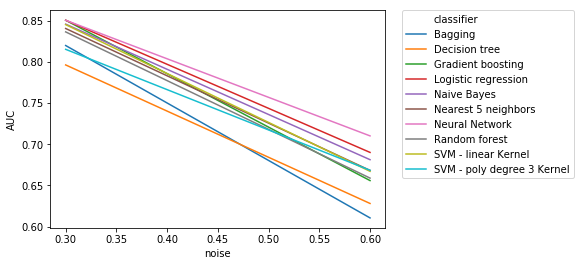

In [33]:
plot_results(results, 'andSplit', 'AUC')

We can observe the following:

* When the noise is 0.3, the Gradient Boosting classifier performs the best. Nonetheless, the performance of all the classifiers remains close
* When the noise is increased to 0.6, The two better classifiers are Logistic Regression, Naive Bayes and the SVM with a linear kernel
* This behavior happens because this type of data generation creates two well-defined classification areas that can be easily splitted by a linear decision boundary. In general, with this type of data and a low noise, we could expect that almost any classifier will perform well
* When the noise is increased, our linear-boundary classifiers (linear-kernel SVM and Logistic Regression) become the best performers because their decision boundary is specially set for this type of data. The Naive Bayes perform well because the features of this data were generated with independent random distributions.

Checking `xorSplit`:

,data generation,noise,classifier,AUC
0,xorSplit,0.30,Bagging,0.836034
1,xorSplit,0.30,Decision tree,0.770308
2,xorSplit,0.30,Gradient boosting,0.804822
3,xorSplit,0.30,Logistic regression,0.536114
4,xorSplit,0.30,Naive Bayes,0.513605
5,xorSplit,0.30,Nearest 5 neighbors,0.850340
6,xorSplit,0.30,Neural Network,0.865246
7,xorSplit,0.30,Random forest,0.825630
8,xorSplit,0.30,SVM - linear Kernel,0.545918
9,xorSplit,0.30,SVM - poly degree 3 Kernel,0.720188


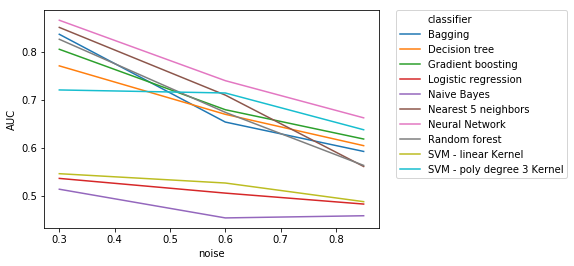

In [34]:
plot_results(results, 'xorSplit', 'AUC')

Some trends in this case:

* When the noise is low (0.3), the classifiers with the better metrics are the K-Neighbors, the Neural Network and Gradient Boosting.
* When the noise is 0.6, the best classifiers are Gradient Boosting and Neural Network.
* When the noise is the highest (0.85), the Neural Network is the better classifier.
* This type of data is more complex than the previous one, and it is hard to classify it with a single decission boundary.
* The Neural Network performs clearly better than every other classifier for this type of data. This is possibly due to the adaptative nature of this type of classifier.

For the `targetSplit` type:

,data generation,noise,classifier,AUC
0,targetSplit,0.30,Bagging,0.825830
1,targetSplit,0.30,Decision tree,0.800120
2,targetSplit,0.30,Gradient boosting,0.845638
3,targetSplit,0.30,Logistic regression,0.510804
4,targetSplit,0.30,Naive Bayes,0.860744
5,targetSplit,0.30,Nearest 5 neighbors,0.836234
6,targetSplit,0.30,Neural Network,0.865846
7,targetSplit,0.30,Random forest,0.826030
8,targetSplit,0.30,SVM - linear Kernel,0.600340
9,targetSplit,0.30,SVM - poly degree 3 Kernel,0.500000


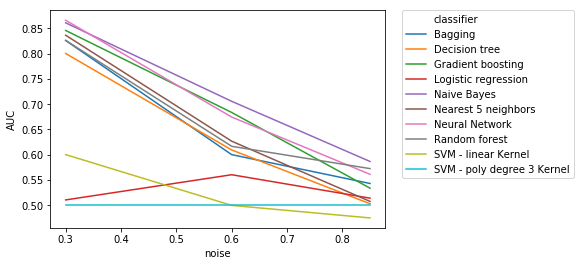

In [35]:
plot_results(results, 'targetSplit', 'AUC')

We can observe the following:

* The Neural Network is, once again, consistently the best classifier then the noise is not very high.
* When the noise is low, almost every classifier exhibits a fairly good performance.
* When the noise is very high (0.85), every classifier performs slightly better than a random assignment, where the AUC value is 0.5.
* This happens for the way this data generator is laid out: the target split **and** a high noise behave close to purely randomly-generated data.
* The reason why the Neural Network performs consistently better than the other classifiers is that can adapt the best to the type of decision boundary this data has. In general, the Neural Networks adapt well to non-linear boundaries.

,data generation,noise,classifier,AUC
0,multiBlobs,0.3,Bagging,0.886194
1,multiBlobs,0.3,Decision tree,0.878489
2,multiBlobs,0.3,Gradient boosting,0.885317
3,multiBlobs,0.3,Logistic regression,0.886529
4,multiBlobs,0.3,Naive Bayes,0.907767
5,multiBlobs,0.3,Nearest 5 neighbors,0.880939
6,multiBlobs,0.3,Neural Network,0.910583
7,multiBlobs,0.3,Random forest,0.881954
8,multiBlobs,0.3,SVM - linear Kernel,0.910877
9,multiBlobs,0.3,SVM - poly degree 3 Kernel,0.888547


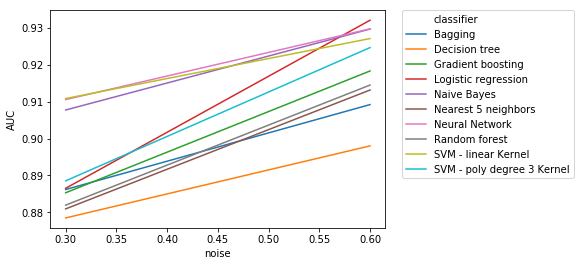

In [36]:
plot_results(results, 'multiBlobs', 'AUC')

We can see the following:

* In general, every classifier has a very high performance across the two levels of noise.
* This might be because in this type of data every classification space is usually well-defined.
* Once again, the Neural Network consistently outperforms most of the other classifiers.

## My solution with real data

Now I'll load the real data and conduct the same analysis

In [37]:
reddit = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
news_groups = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
senate_small = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
senate_large = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
spam = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Reddit data
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading senate data
Converting to vectors
Loading senator: Kennedy
Loading senator: Kerry
Loading senator: Klobuchar
Loading senator: Kohl
Loading senator: Kyl
Converting to vectors
Loading Spam
Loading Ham
Converting to vectors


In [38]:
real_data = {'reddit': reddit,
             'news_groups': news_groups,
             'senate small': senate_small,
             'senate_large': senate_large,
             'spam': spam}

In [39]:
results_real_data = pandas.DataFrame(columns=['dataset', 'classifier', 'Category',
                                              'Error_Rate', 'AUC', 'Precision',
                                              'Average_Precision', 'Recall'])

random.seed(818377)
for set_name, data in real_data.items():
    
    train, test = data
    
    for clf_key, clf in classifiers.items():
        
        clf.fit(np.stack(train['vect'], axis=0), train['category'])
        local_results = lucem_illud_2020.evaluateClassifier(clf, test).reset_index()
        
        df = pandas.DataFrame()
        df['dataset'] = [set_name] * len(local_results)
        df['classifier'] = [clf_key] * len(local_results)
        
        df = pandas.concat([df,local_results],axis=1)
        results_real_data = pandas.concat([results_real_data, df], axis=0).reset_index(drop=True)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarnin

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [40]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [41]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [42]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Let's split the data into training data and testing data.

In [43]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [44]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [45]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [46]:
TFVects.shape

(1368, 11336)

We can save this in the dataframe to make things easier

In [47]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approach this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [48]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [49]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


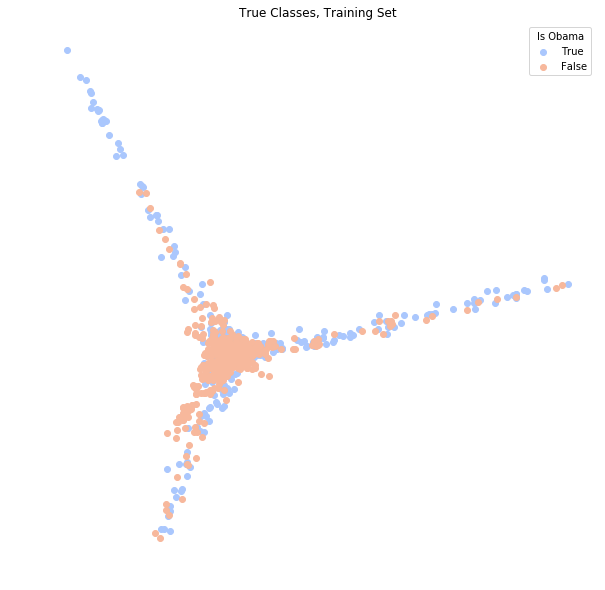

In [50]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

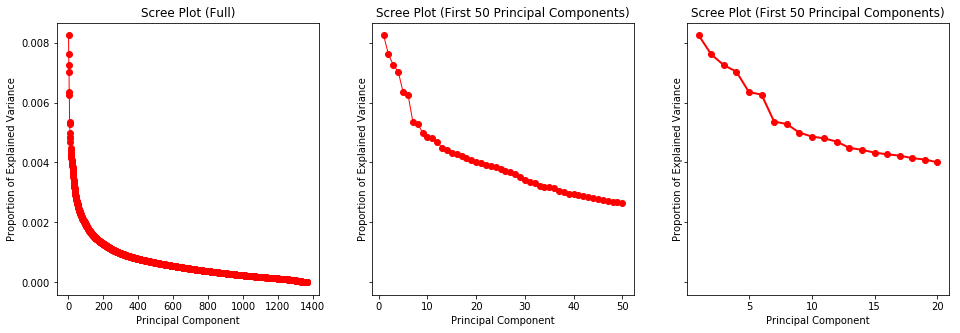

In [51]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [52]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


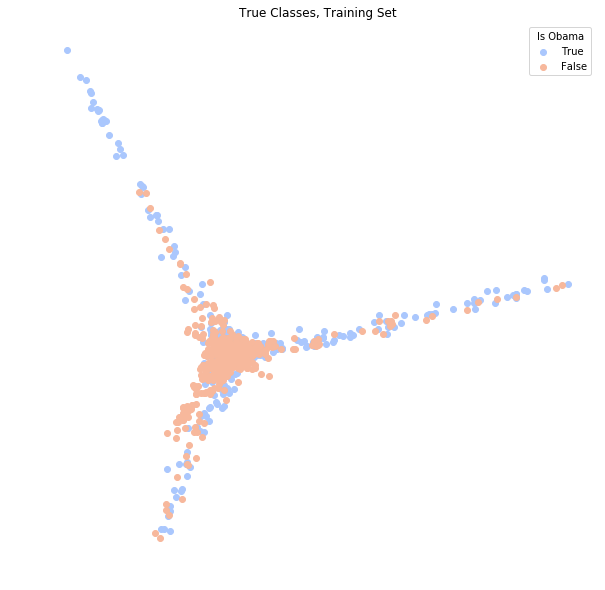

In [53]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca_reduced_10'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca_reduced_10'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

Now we fit a logistic regression to our data.

In [54]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [55]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6849415204678363

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [56]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.656891495601173

Slightly poorer. How about using more dimensions (40)?

In [57]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7317251461988304
Testing:
0.718475073313783


Or still more (100)?

In [58]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8326023391812866
Testing:
0.782991202346041


Or even more (200)!

In [59]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8640350877192983
Testing:
0.8181818181818182


This is becoming ridiculous (400)!

In [60]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9115497076023392
Testing:
0.8387096774193549


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [61]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9583333333333334


Train the model using training data, and then test it on the testing data.

In [62]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8533724340175953


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [63]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [64]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9692982456140351
Testing:
0.9178885630498533


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [65]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [66]:
sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'])

0.918918918918919

Recall:

In [67]:
sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'])

0.8947368421052632

F1-measure:

In [68]:
sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'])

0.9066666666666667

Let's take a look at how well our posterior distribution looks relative to the truth.

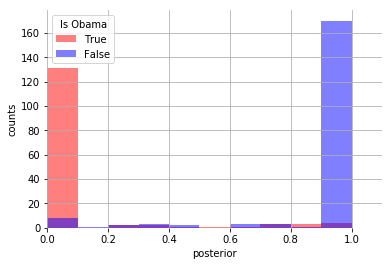

In [69]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [70]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Clinton,Clinton_log_prob,Obama,Obama_log_prob
0,5566,-1.748312,signature,-2.218462
1,friday,-1.789985,island,-2.264982
2,monday,-1.867372,awarded,-2.339090
3,amy,-1.878932,fy,-2.339090
4,dick,-1.914439,welcomed,-2.339090
5,brundage,-1.976571,ground,-2.351993
6,chicago,-1.976571,point,-2.391734
7,reform,-2.190145,having,-2.433119
8,writing,-2.222406,read,-2.433119
9,practices,-2.255742,entire,-2.447304


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [71]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [72]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [73]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [74]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [75]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [76]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [77]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [78]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8821822402785838


In [79]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
1393,sci.space,sci.space
1796,comp.graphics,comp.graphics
63,talk.religion.misc,talk.religion.misc
1079,sci.space,sci.space
1601,comp.graphics,comp.graphics
619,soc.religion.christian,soc.religion.christian
1766,comp.graphics,comp.graphics
280,talk.religion.misc,talk.religion.misc
259,talk.religion.misc,talk.religion.misc
1099,sci.space,sci.space


Looks pretty good, lets examine the testing dataset:

In [80]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7627906976744186


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

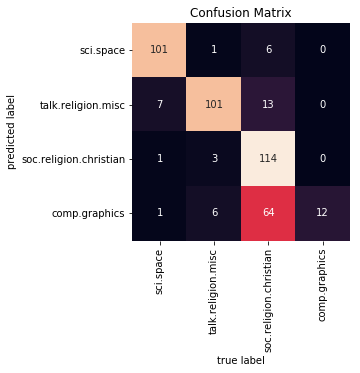

In [81]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [82]:
# Precision
print(sklearn.metrics.precision_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #precision
# Recall
print(sklearn.metrics.recall_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #recall
#F-1
print(sklearn.metrics.f1_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #F-1 measure

0.9013493874178955
0.7627906976744186
0.8004539822478364


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [83]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
talk.religion.misc,0.572289,0.309695,0.165116,1.000000,0.144578
soc.religion.christian,0.850038,0.568366,0.202326,0.578680,0.966102
sci.space,0.901174,0.806023,0.069767,0.909910,0.834711
comp.graphics,0.953617,0.874949,0.037209,0.918182,0.935185


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

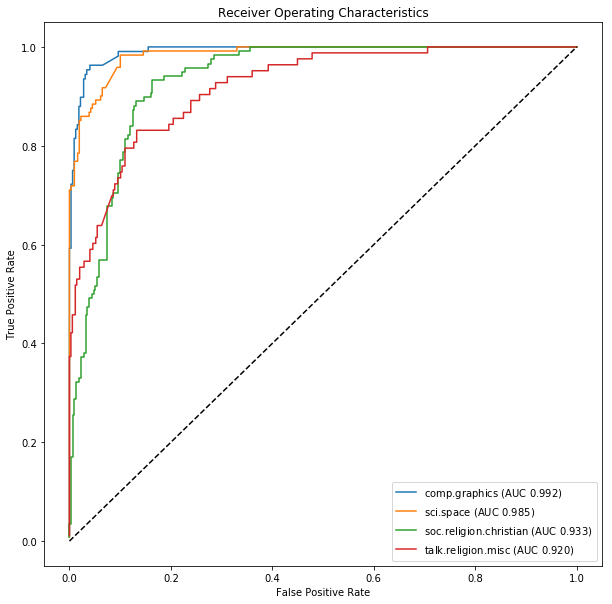

In [84]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

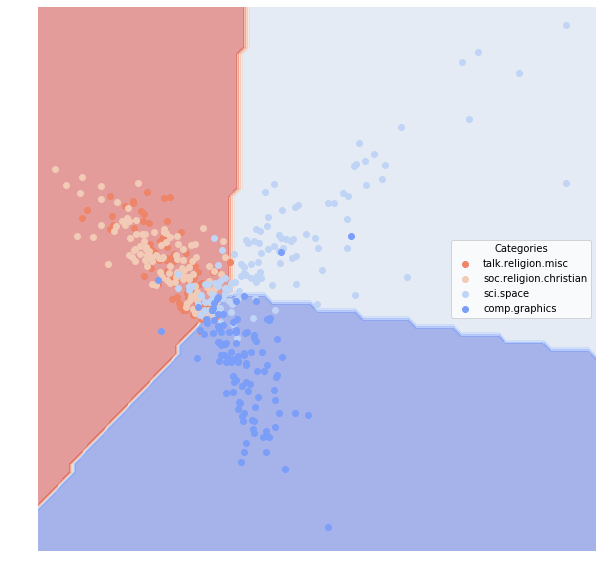

In [85]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Extrapolate codes from these models to all uncoded data.

## My solution

First, I'll load my dataset of classified instances:

In [86]:
data = pandas.read_csv('train_set.csv')

Now I'll create a column with the `True` categories:

In [87]:
data['category'] = [label == 1 for label in data['labels']]

Tokenizing:

In [88]:
data['tokenized_text'] = data['sentence'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
data['normalized_text'] = data['sentence'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Separating the train/test sets:

In [89]:
random.seed(984833)
holdBackFraction = .2
train_df, test_df = lucem_illud_2020.trainTestSplit(data, holdBackFraction=holdBackFraction)
print(len(train_df))
print(len(test_df))

80
20


### Logistic regression

Converting the training dataframe into a tf-idf matrix:

In [90]:
train_df_logistic = train_df[:]
test_df_logistic = test_df[:]

In [91]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_df_logistic['sentence'])

Saving this into the training dataframe:

In [92]:
train_df_logistic['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Generating and saving the PCA of `vect`:

In [93]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_df_logistic['vect'], axis=0))
train_df_logistic['pca'] = [row for row in reduced_data]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
reduced_data.shape

(80, 80)

Now I'll overwrite the `vect` column to store the first 20 values of the PCA:

In [95]:
train_df_logistic['vect'] = train_df_logistic['pca'].apply(lambda x: x[:20])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now I'll use these different `pca` variables to train my model. I'll use an `l2` penalizer for this model:

In [96]:
logistic = sklearn.linear_model.LogisticRegression(penalty='l2')
logistic.fit(np.stack(train_df_logistic['vect'], axis=0), train_df_logistic['category'])
logistic.score(np.stack(train_df_logistic['vect'], axis=0), train_df_logistic['category'])

0.625

To see how well this classifier performs on the test set, I'll repeat this process with it:

In [97]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_df_logistic['sentence'])
test_df_logistic['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_df_logistic['vect'], axis=0))
test_df_logistic['pca'] = [row for row in reduced_data_test]
test_df_logistic['vect'] = test_df_logistic['pca'].apply(lambda x: x[:20])

#Test
logistic.score(np.stack(test_df_logistic['vect'], axis=0), test_df_logistic['category'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

0.65

The mean accuracy ofthe test set seems ok. I'll save the other metrics in a dataframe now to compare them with my other classifiers:

In [98]:
performance_logistic = lucem_illud_2020.evaluateClassifier(logistic, test_df_logistic)
# F1-measure:
test_df_logistic['logistic_predict'] = logistic.predict(np.stack(test_df_logistic['vect'], axis=0))
f1_logistic = sklearn.metrics.f1_score(test_df_logistic['category'], test_df_logistic['logistic_predict'])

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Naive Bayes

I'll repeat the procedure to train a Naive Bayes classifier. I'll continue to use the tf-idf vectors here.

In [99]:
train_df_nb = train_df[:]
test_df_nb = test_df[:]

In [100]:
TFVects_test = TFVectorizer.transform(train_df_nb['sentence'])
train_df_nb['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [101]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_df_nb['vect'], axis=0), train_df_nb['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [102]:
TFVects_test = TFVectorizer.transform(test_df_nb['sentence'])
test_df_nb['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [103]:
print("Training mean accuracy:")
print(naiveBayes.score(np.stack(train_df_nb['vect'], axis=0), train_df_nb['category']))
print("Testing mean accuracy:")
print(naiveBayes.score(np.stack(test_df_nb['vect'], axis=0), test_df_nb['category']))

Training mean accuracy:
0.9625
Testing mean accuracy:
0.55


In [104]:
performance_naive_bayes = lucem_illud_2020.evaluateClassifier(naiveBayes, test_df_nb)
test_df_nb['nb_predict'] = naiveBayes.predict(np.stack(test_df_nb['vect'], axis=0))
f1_nb = sklearn.metrics.f1_score(test_df_nb['category'], test_df_nb['nb_predict'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Comparing Logistic Regression and Naive Bayes

In [105]:
performance_logistic

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
False,0.5,0.35,0.35,0.00,0.0
True,0.5,0.65,0.35,0.65,1.0


In [106]:
performance_naive_bayes

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
False,0.489011,0.345238,0.45,0.333333,0.285714
True,0.489011,0.645055,0.45,0.642857,0.692308


In general, the Logistic Regression classifier performs slightly better than the Naive, though its precision is zero. Both classifiers are bad for this task.

Comparing the F1:

In [107]:
print('Logistic regression F1:', f1_logistic)
print('Naive Bayes F1:', f1_nb)

Logistic regression F1: 0.787878787878788
Naive Bayes F1: 0.6666666666666666


The Logistic Regression outperforms the Naive Bayes classifier.

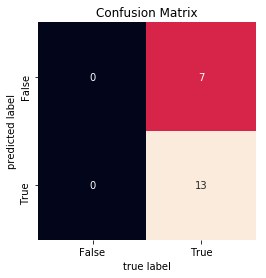

In [108]:
lucem_illud_2020.plotConfusionMatrix(logistic, test_df_logistic)

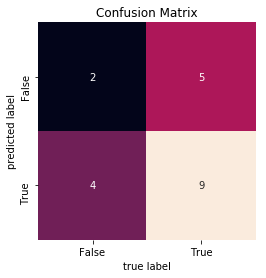

In [109]:
lucem_illud_2020.plotConfusionMatrix(naiveBayes, test_df_nb)

**Important:** It seems that there's a bug in the output of the `plotConfusionMatrix()` command. The true labels are actually in the rows and the predicted labels in the columns. Also, the labels `True` and `False` are actually the `False` and `True` ones in the rows and columns.

Having noticed this, we see that both classifiers fail to predict the true `False` cases, which we had already noted in the low recall they have. The Confusion Matrix shows this too. The Logistic Regression has better overall accuracy, though the Naive Bayes distributes it better accross the true `True` and `False` instances.

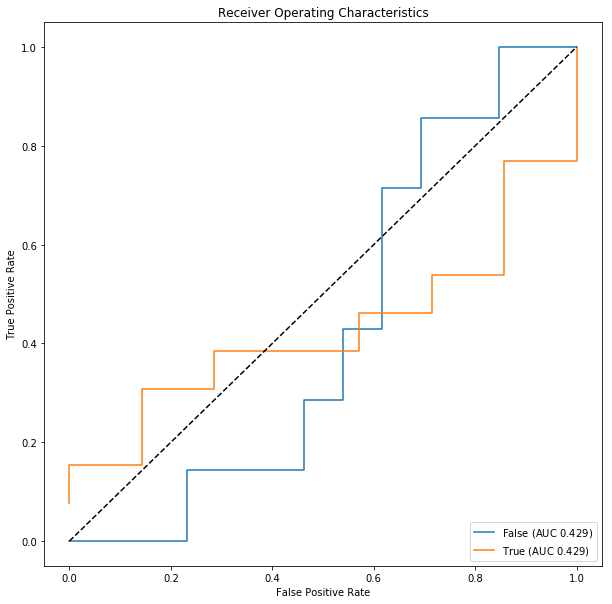

In [110]:
lucem_illud_2020.plotMultiROC(logistic, test_df_logistic)

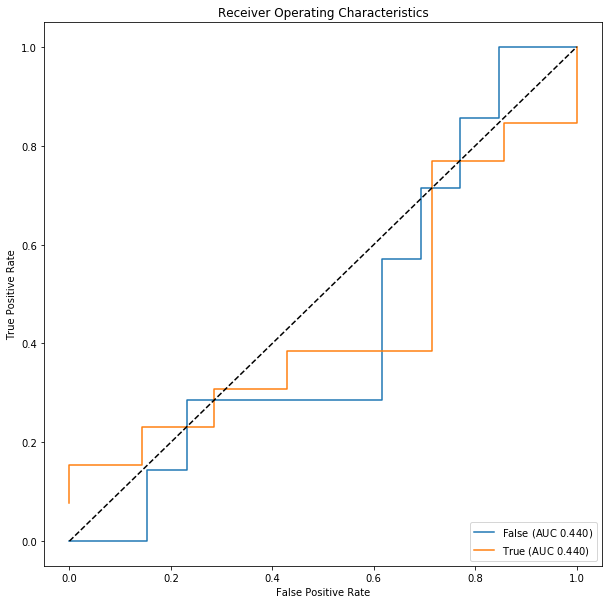

In [111]:
lucem_illud_2020.plotMultiROC(naiveBayes, test_df_nb)

These ROC curves also indicate a poor behavior. In general, these classifiers perform bad for this data.

Finally, I extrapolate these two classifiers to my uncoded data.

In [112]:
uncoded_data = pandas.read_csv('../week-2/uncoded_sentences.csv')
TFVects_uncoded = TFVectorizer.transform(uncoded_data['sentence'])
uncoded_data['vect'] = [np.array(v).flatten() for v in TFVects_uncoded.todense()]
reduced_data_uncoded = pca.transform(np.stack(uncoded_data['vect'], axis=0))
uncoded_data['pca'] = [row for row in reduced_data_uncoded]
uncoded_data['pca_20'] = uncoded_data['pca'].apply(lambda x: x[:20])

In [113]:
uncoded_data['nb_predict'] = naiveBayes.predict(np.stack(uncoded_data['vect'], axis=0))
uncoded_data['logistic_predict'] = logistic.predict(np.stack(uncoded_data['pca_20'], axis=0))

In [114]:
uncoded_data['nb_predict'].value_counts()

True     208
False     95
Name: nb_predict, dtype: int64

In [115]:
uncoded_data['logistic_predict'].value_counts()

True     294
False      9
Name: logistic_predict, dtype: int64

It seems that the Naive Bayes is better for this prediction than the Logistic Regression. The latter gives a ridiculous amount of only 5 `False` instances.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

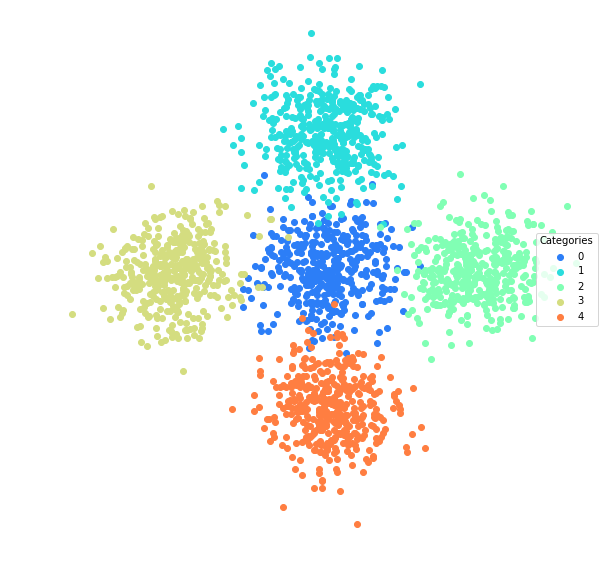

In [116]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [117]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

To see what's going on visually with the classification: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

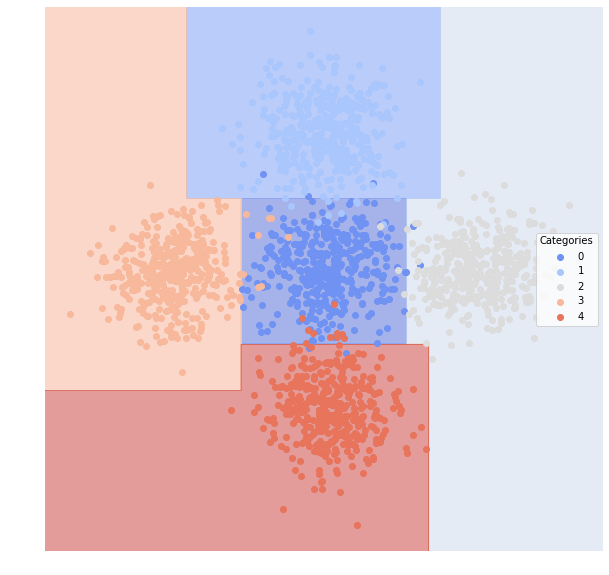

In [118]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [119]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.989841,0.951600,0.010,0.959596,0.989583
1,0.998768,0.989474,0.002,0.989474,1.000000
2,0.990566,0.985132,0.004,1.000000,0.981132
3,0.989465,0.976309,0.006,0.990654,0.981481
4,0.994792,0.991583,0.002,1.000000,0.989583


Lets look at accuracy:

In [120]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.988

What happens if we trim the tree?

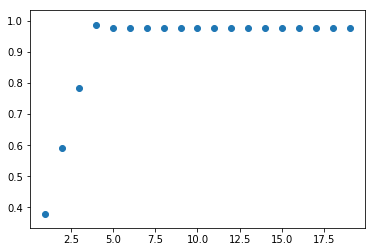

In [121]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [122]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [123]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

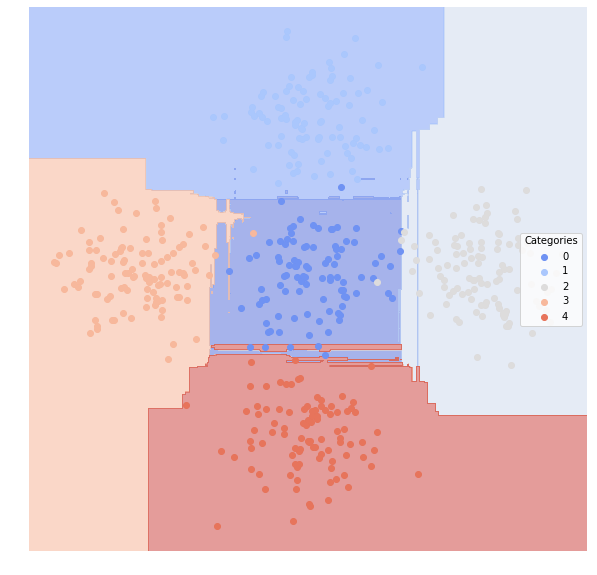

In [124]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [125]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.962562,0.900158,0.022,0.947368,0.937500
1,0.998768,0.989474,0.002,0.989474,1.000000
2,0.990566,0.985132,0.004,1.000000,0.981132
3,0.989465,0.976309,0.006,0.990654,0.981481
4,0.989841,0.951600,0.010,0.959596,0.989583


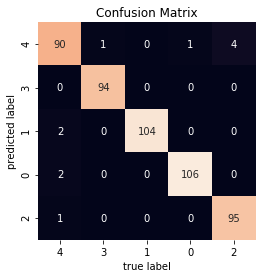

In [126]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [127]:
newsgroupsDF[:5]

,category,source_file,text,tokenized_text,normalized_text
0,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,\n\nParadise and salvation are not the same th...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, better..."
1,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,\nYou're admitting a lot more than that. You ...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"\n\nJesus also recognized other holy days, lik...","[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"\nI'm sorry, but He does not! Ever read the F...","[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [128]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [129]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [130]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [131]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [132]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
talk.religion.misc,0.592399,0.224153,0.220546,0.342105,0.307432
soc.religion.christian,0.504158,0.285159,0.276843,1.000000,0.008316
sci.space,0.603074,0.339393,0.469530,0.354630,0.773737
comp.graphics,0.556114,0.291739,0.321532,0.361930,0.299335


And lets look at the testing data

In [133]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.2302325581395349


Let's produce another confusion matrix:

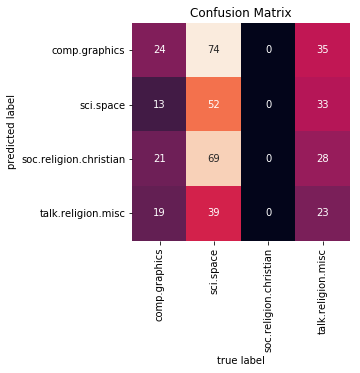

In [134]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [135]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [136]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [137]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [138]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [139]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

...and consider the results:

In [140]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.981339,0.928786,0.021944,0.936170,0.988764
Tales From Tech Support,0.991588,0.977979,0.006270,0.987342,0.987342
Weeaboo Tales: stories about the extreme fans of japanese culture,0.988157,0.956508,0.009404,0.968750,0.984127
Relationships,0.965909,0.950627,0.018809,1.000000,0.931818


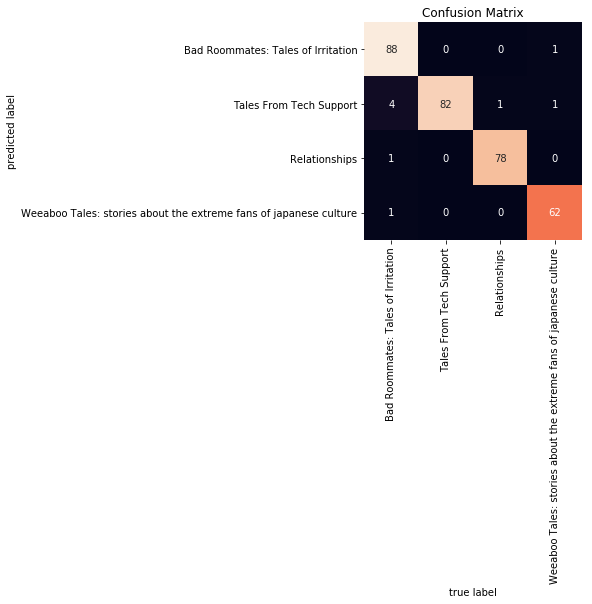

In [141]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

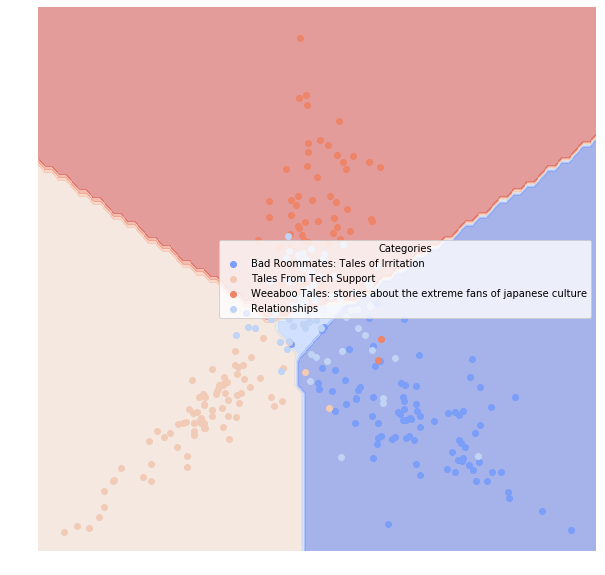

In [142]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [143]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [144]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.987860,0.959302,0.012539,0.967033,0.988764
Tales From Tech Support,0.991588,0.977979,0.006270,0.987342,0.987342
Weeaboo Tales: stories about the extreme fans of japanese culture,0.988157,0.956508,0.009404,0.968750,0.984127
Relationships,0.975108,0.955855,0.015674,0.988235,0.954545


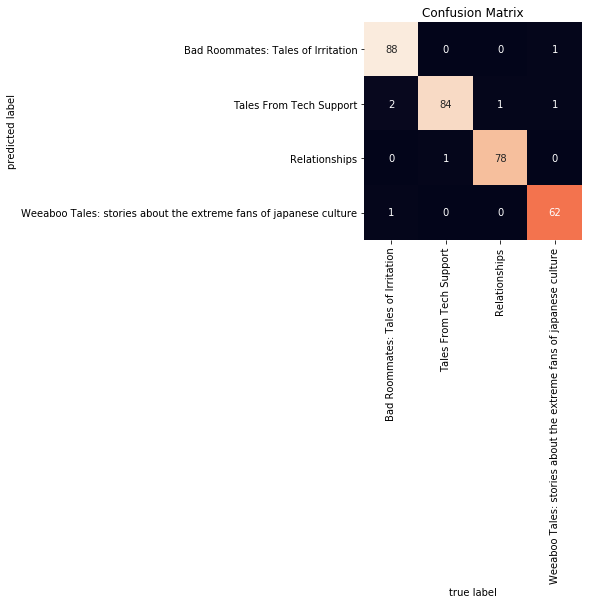

In [145]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

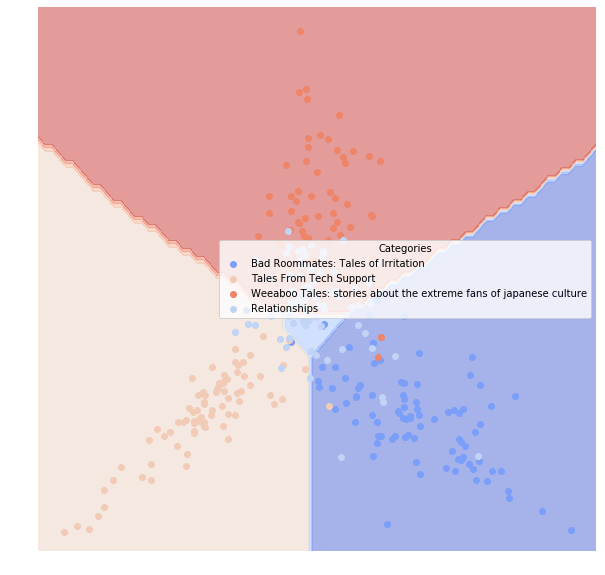

In [146]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?